In [1]:
from helpers import *
from implementations import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = './data/'
#data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/MilaLyon/data/"
#data_folder = "C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/MilaLyon/data/"

In [3]:
csv_data = load_csv_data(data_folder, max_rows=None, dictionnary=True)

# Replace zeros and default values before preprocessing
convert_to_times_per_week(csv_data['x_train'], csv_data['bad_format_no_better'])
convert_to_times_per_week(csv_data['x_test'], csv_data['bad_format_no_better'])
replace_by_zero(csv_data['x_train'], csv_data['x_test'], csv_data['zero_values'])
replace_default_with_nan(csv_data['x_train'], csv_data['x_test'], csv_data['default_values'])

def print_shapes(data):
    for key, value in data.items():
        print(f"{key}: {type(value)} with shape {value.shape if isinstance(value, np.ndarray) else 'N/A'}")
print_shapes(csv_data)


x_train: <class 'numpy.ndarray'> with shape (328135, 321)
x_test: <class 'numpy.ndarray'> with shape (109379, 321)
y_train: <class 'numpy.ndarray'> with shape (328135,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (321,)
useless: <class 'numpy.ndarray'> with shape (321,)
health_related: <class 'numpy.ndarray'> with shape (321,)
better_elsewhere: <class 'numpy.ndarray'> with shape (321,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (321,)
binary: <class 'numpy.ndarray'> with shape (321,)
one_hot: <class 'numpy.ndarray'> with shape (321,)
zero_values: <class 'numpy.ndarray'> with shape (321,)
default_values: <class 'numpy.ndarray'> with shape (321,)


In [4]:
def preprocess_data(data, nan_drop_threshold=0.2, correlation_threshold=0.02, n_std=3, only_health_related=True, split_val=False, val_size=0.1):

    # Identify and drop features with many missing values
    nan_features = identify_too_many_missing(data["x_train"], data["feature_names"], threshold=nan_drop_threshold)
    drop_features_from_dictionnary(data, nan_features)
    print(len(nan_features), "features with too many missing values dropped.")

    # Replace remaining NaNs with either mean or most frequent value
    replace_nan(data["x_train"], data["x_test"])

    # Keep only health-related features if specified
    if only_health_related:
        non_health_features = data['feature_names'][~data['health_related']].tolist()
        drop_features_from_dictionnary(data, non_health_features)
        print(len(non_health_features), "non health-related features dropped.")

    # One-hot encode categorical features
    n_features_before = data['x_train'].shape[1]
    one_hot_encode(data)
    n_features_after = data['x_train'].shape[1]
    print(f"One-hot encoding completed. Number of features increased from {n_features_before} to {n_features_after}.")

    # Identify and drop features with low correlation to the target
    low_corr_features, _ = identify_low_correlation(data["x_train"], data["y_train"], data["feature_names"], threshold=correlation_threshold)
    drop_features_from_dictionnary(data, low_corr_features)
    print(len(low_corr_features), "features with low correlation dropped.")

    #Clip outliers
    clip_outliers(data['x_train'], data['x_test'], n_std=n_std)

    #Normalize features
    data['x_train'], data['x_test'] = min_max_normalize(data['x_train'], data['x_test'])
    data['y_train'] = (data['y_train'] == 1).astype(int)

    if split_val:
        data['x_train'], data['y_train'], data['x_val'], data['y_val'] = split_train_val(data['x_train'], data['y_train'], val_size=val_size)


In [5]:
data_copy = dict(csv_data)
preprocess_data(data_copy, nan_drop_threshold=0.9, correlation_threshold=0.01, n_std=3, only_health_related=False, split_val=True, val_size=0.1)

99 features with too many missing values dropped.
One-hot encoding completed. Number of features increased from 222 to 512.


c:\Users\natha\miniforge3\envs\ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\natha\miniforge3\envs\ml\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


215 features with low correlation dropped.
Clipped 1857428 values in x_train (1.91% of all entries)
Clipped 619268 values in x_test (1.91%)


In [6]:
print_shapes(data_copy)

x_train: <class 'numpy.ndarray'> with shape (295322, 297)
x_test: <class 'numpy.ndarray'> with shape (109379, 297)
y_train: <class 'numpy.ndarray'> with shape (295322,)
train_ids: <class 'numpy.ndarray'> with shape (328135,)
test_ids: <class 'numpy.ndarray'> with shape (109379,)
feature_names: <class 'numpy.ndarray'> with shape (297,)
useless: <class 'numpy.ndarray'> with shape (297,)
health_related: <class 'numpy.ndarray'> with shape (297,)
better_elsewhere: <class 'numpy.ndarray'> with shape (297,)
bad_format_no_better: <class 'numpy.ndarray'> with shape (297,)
binary: <class 'numpy.ndarray'> with shape (297,)
one_hot: <class 'numpy.ndarray'> with shape (297,)
zero_values: <class 'numpy.ndarray'> with shape (297,)
default_values: <class 'numpy.ndarray'> with shape (709,)
x_val: <class 'numpy.ndarray'> with shape (32813, 297)
y_val: <class 'numpy.ndarray'> with shape (32813,)


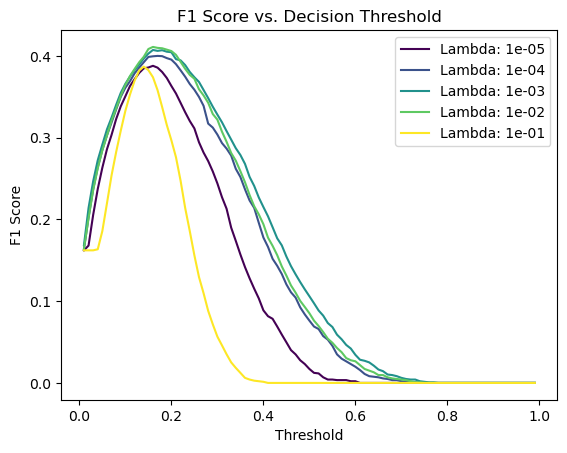

In [7]:
initial_w = np.zeros(data_copy['x_train'].shape[1])

lambdas = [10**i for i in range(-5, 0)]
thresholds = [i / 100 for i in range(1, 100)]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
for i, lam in enumerate(lambdas):
    w, loss = reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], lam, initial_w, 1000, 0.01)
    accuracies = []
    f1s = []
    for threshold in thresholds:
        y_pred = predict_labels_logistic(data_copy['x_val'], w, threshold=threshold)
        scores = compute_scores(data_copy['y_val'], y_pred)
        accuracies.append(scores['accuracy'])
        f1s.append(scores['f1_score'])
    plt.plot(thresholds, f1s, label=f"Lambda: {lam:.0e}", color=colors[i])

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.show()

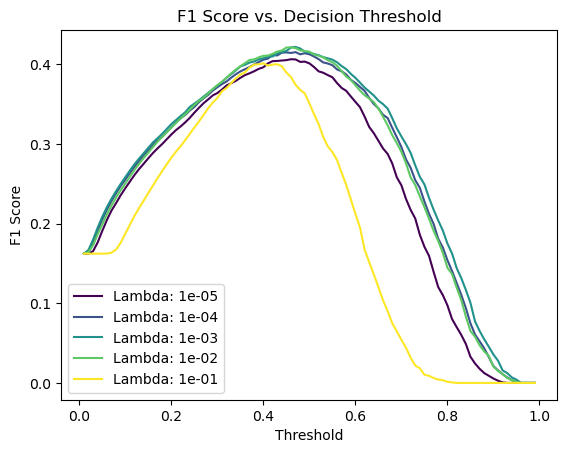

In [10]:
initial_w = np.zeros(data_copy['x_train'].shape[1])
# Define sample weights: weight of 1 for class 0 and weight of 4 for class 1
sample_weights = 1 + 3*data_copy['y_train']

lambdas = [10**i for i in range(-5, 0)]
thresholds = [i / 100 for i in range(1, 100)]
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))
for i, lam in enumerate(lambdas):
    w, loss = weighted_reg_logistic_regression(data_copy['y_train'], data_copy['x_train'], lam, sample_weights, initial_w, 1000, 0.01)
    accuracies = []
    f1s = []
    for threshold in thresholds:
        y_pred = predict_labels_logistic(data_copy['x_val'], w, threshold=threshold)
        scores = compute_scores(data_copy['y_val'], y_pred)
        accuracies.append(scores['accuracy'])
        f1s.append(scores['f1_score'])
    plt.plot(thresholds, f1s, label=f"Lambda: {lam:.0e}", color=colors[i])

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.legend()
plt.show()

In [ ]:
test_pred = predict_labels_logistic(data_copy['x_test'], w, threshold=0.5)
#Convert test_pred to 1 and -1
test_pred = np.where(test_pred == 1, 1, -1)
create_csv_submission(data_copy['test_ids'], test_pred, 'logistic_regression_submission.csv')